# Forcing an Output in a Neural Network

Welcome to this notebook! This will be a brief look into neural networks and how they can be manipulated. I'll be looking at a toy example using the MNIST dataset and how to craft inputs for high confidence outputs. See the repo for dependency installation. I'm running this notebook on Windows 10 with Python 3.8 in a VirtualEnv environment.

## Part 1: Setting up the initial model

First, let's set up the initial model we want to manipulate. I'll be using the example neural network from the Tensorflow documentation, found [here](https://www.tensorflow.org/datasets/keras_example). I've joined it into a single cell to immediately train the network in one shot.

In [1]:
# Example ripped straight from: https://www.tensorflow.org/datasets/keras_example
# https://github.com/tensorflow/datasets/blob/8723d84a971cfbcc7e09328d267718f2d7559fee/docs/keras_example.ipynb
# Accessed 2020-09-05

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
tf.enable_v2_behavior()

###########################################

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

###########################################

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

###########################################

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

###########################################

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

###########################################
print("Model trained!")

Epoch 1/6
469/469 [==============================] - 1s 3ms/step - loss: 0.3601 - accuracy: 0.8996 - val_loss: 0.1958 - val_accuracy: 0.9442
Epoch 2/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1658 - accuracy: 0.9526 - val_loss: 0.1398 - val_accuracy: 0.9602
Epoch 3/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1186 - accuracy: 0.9661 - val_loss: 0.1106 - val_accuracy: 0.9671
Epoch 4/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0916 - accuracy: 0.9740 - val_loss: 0.0970 - val_accuracy: 0.9707
Epoch 5/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0741 - accuracy: 0.9786 - val_loss: 0.0878 - val_accuracy: 0.9741
Epoch 6/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0605 - accuracy: 0.9828 - val_loss: 0.0830 - val_accuracy: 0.9749
Model trained!


Now that the model is trained, we can call it as a function with some piece of data and see how well it works.

Predicted number is: 2
Confidence of predicted number is 0.9999812841415405


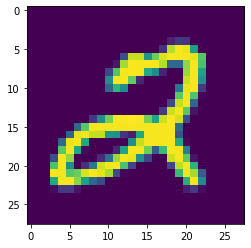

In [2]:
import matplotlib.pyplot as plt # visualization
import numpy as np # matrices and number operations

test_input = ds_test.as_numpy_iterator().next()[0][0].reshape((1,28,28,1)) # brute forcing here; this can probably be optimized
plt.imshow(test_input.reshape((28,28)))
test_output = model(test_input)

print("Predicted number is: {}".format(np.argmax(test_output))) # output is vector of confidence levels for 0-9 in that order
print("Confidence of predicted number is {}".format(np.max(test_output)))
plt.show()

## Part 2: Manipulating the original model

Now that we can tell that the network is working as intended, let's manipulate some input so that we can get an equivalent confidence. The way I plan to do this is by generating an image and letting a neural network adjust its weights so that it eventually produces a winning combination of pixels. Overfitting is the name of the game here. First, let's see if we can confidently get a 2 in return.

In [3]:
desired_label = 2 # the output we want. change this and rerun all following steps as desired

This next part generates a dataset for breaking the original network. It's a single image of all ones (an all-white image), and we don't need any more images than that. If we were to do batch processing on a larger set of the same images, we would be calculating the average error of all images in a single batch against the same weights on the network. Because the inputs and weights are not changing in a single batch, we will have the same outputs (and thus the same error) for each entry in the batch. The average error of identical inputs is exactly the same as running the image once, so it's way more efficient to use one image per epoch. Feel free to edit the numbers below to see for yourself.

In [4]:
number_of_samples = 1
batch_size = 1
blank_images = np.ones((number_of_samples, 28, 28, 1)) # make a dataset of 1 (28, 28, 1) white image
blank_image_labels = np.ones((number_of_samples, 1), np.int64) * desired_label
breaking_dataset = tf.data.Dataset.from_tensor_slices((blank_images, blank_image_labels))
breaking_dataset = breaking_dataset.batch(batch_size)
print("Input shape: {}, Output shape: {}".format(blank_images.shape, blank_image_labels.shape))

Input shape: (1, 28, 28, 1), Output shape: (1, 1)


Now comes the fun part- let's set up a network to generate images for the original network. We've already established a dataset that will overfit output 2, and the objective is to input *any* image that will produce a high confidence 2. In this case, my input can be anything as long as the output is a valid image of shape (1, 28, 28, 1), so I'm relying on the weights of my malicious neural network to adjust rather than adjust the input image itself. I only care about getting one valid output from the original neural network, so I only need one good image as an input. I can repeat this process for the other 9 outputs.

In [5]:
#freeze the original model so it is deterministic and doesn't change
for layer in model.layers:
    layer.trainable = False

malicious_model = tf.keras.models.Sequential([ #arbitrary network, feel free to adjust
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(28*28, activation='sigmoid'), # limit image vals from 0.0 to 1.0 with sigmoid
  tf.keras.layers.Reshape((28, 28, 1))
])

malicious_model_training = tf.keras.models.Sequential([
    malicious_model, # trainable model, generates the malicicous input
    model # original model with layers frozen
])
    
malicious_model_training.compile( # copying params from the original model
    loss='sparse_categorical_crossentropy', # loss based on original model output
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [6]:
# train model against wanted outputs and the original model
malicious_model_training.fit(
    breaking_dataset,
    epochs=10
)
print("Model trained!")

Epoch 1/10
1/1 [==============================] - 0s 1ms/step - loss: 5.7881 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0383e-04 - accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 983us/step - loss: 1.1921e-07 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.00

tf.Tensor(
[[1.65959017e-19 1.69091803e-24 1.00000000e+00 1.06423785e-24
  2.45125978e-31 3.14384219e-17 5.33208928e-17 2.46429261e-23
  3.27466114e-15 1.13638803e-27]], shape=(1, 10), dtype=float32)
Desired label was: 2
Predicted number is: 2
Confidence of predicted number is 1.0


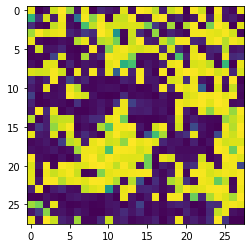

Min value: 0.0020890654996037483, Max value: 0.9973817467689514


In [7]:
test_output = malicious_model_training(blank_images) # generate prediction labels
print(test_output)
print("Desired label was: {}".format(desired_label))
print("Predicted number is: {}".format(np.argmax(test_output))) # output is vector of confidence levels for 0-9 in that order
print("Confidence of predicted number is {}".format(np.max(test_output)))

generated_image = malicious_model(blank_images)
plt.imshow(generated_image[0]) # show the image that generated the output above
plt.show()
print("Min value: {}, Max value: {}".format(np.min(generated_image), np.max(generated_image)))

And to guarantee that we haven't modified the original model, let's predict the same test output from earlier. We are expecting that for the same real image from earlier, the prediction and confidence should exactly match what is shown above, down to all 16 decimal places. The following should show that.

Predicted number is: 2
Confidence of predicted number is 0.9999812841415405


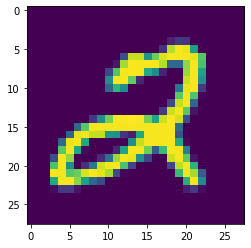

In [8]:
plt.imshow(test_input.reshape((28,28)))
test_output = model(test_input)
print("Predicted number is: {}".format(np.argmax(test_output))) # output is vector of confidence levels for 0-9 in that order
print("Confidence of predicted number is {}".format(np.max(test_output)))
plt.show()